# Controlling the acceleration of the slashing strategy

Previously, we used an affine function to gauge the impact of our slashing on actors based on their individual failure rates. However, it might be more effective to implement a quadratic or even exponential function. This would rapidly eliminate actors who repeatedly fail, and allow those with fewer errors more time to adjust their strategies and become profitable.

For that purpose we need to find out which slash to apply based on wether it is a repeated offense or not.  
Intuitively, I think that the state of the user slash is a good indication of wether he has been acting bad lately or not. If a lot of money has already been slashed it means the user keeps behaving in a non desirable way. We should slash him harder to deter him of continuing.  

The exponential slashing formula is designed to impose increasingly severe penalties on users based on their performance, specifically targeting repeated offenses. The formula used is:
$$
y = \alpha^{x+\beta}+\omega
$$
Here’s what each parameter controls:

$\alpha$: This parameter controls the slope of the exponential curve. A higher value of $\alpha$ makes the penalty increase more rapidly.  
$\beta$: This parameter controls the horizontal shift of the curve. Adjusting $\beta$ shifts the entire curve left or right along the x-axis.  
$\omega$: This parameter controls the vertical shift of the curve. It adjusts the starting point of the penalty on the y-axis.  

See: [Exponential and Logarithmic Functions](https://math.libretexts.org/Courses/Borough_of_Manhattan_Community_College/MAT_206.5/05%3A_Exponential_and_Logarithmic_Functions/5.03%3A_Graphs_of_Exponential_Functions)

In the context of slashing, the variable $x$ represents the reliability of the user, which is calculated as:  

$$
Reliability = \frac{S_0 - S_{current}}{S_0}
$$
​
 
​
 
where $S_0$ is the initial stake and $S_{\text{current}}$ is the current stake of the user. The reliability reflects how much of the initial stake has been slashed.

By using this exponential formula, we can impose steeper penalties on users who continue to perform poorly, effectively deterring repeated offenses while giving users with fewer errors more time to adjust their strategies.

# Implementing the Exponential Slashing Formula in python

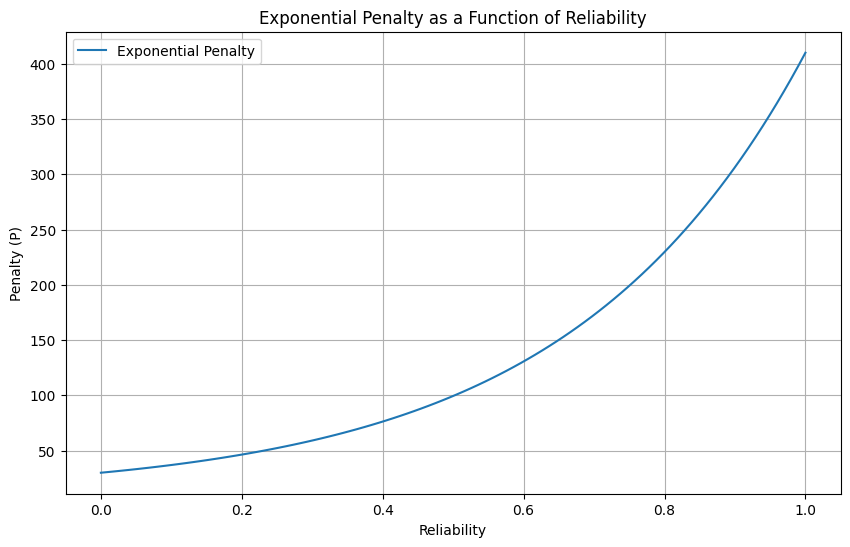

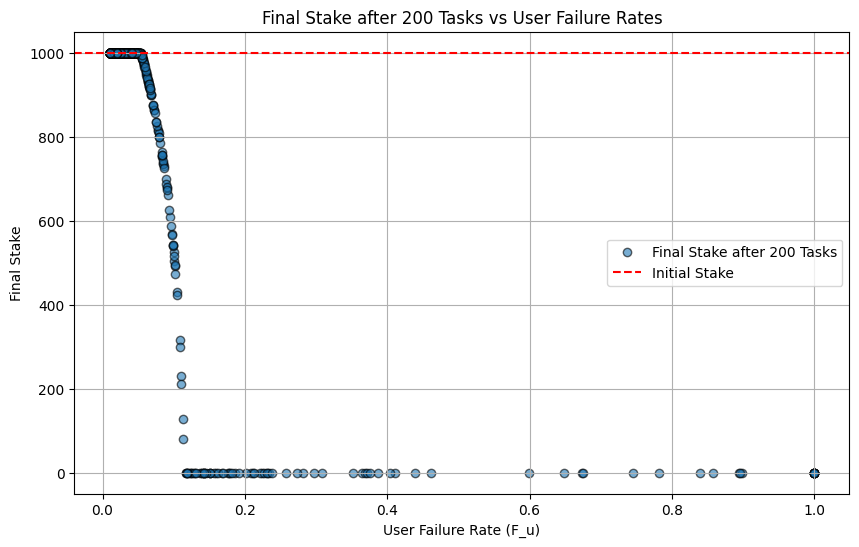

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the overall task failure rate
def calculate_failure_rate(F_u, mean_F_u):
    return 1 - (1 - F_u) * (1 - mean_F_u) ** 3

# Exponential slashing function for penalty P based on remaining stake
def exponential_penalty(reliability, alpha, beta, omega):
    return alpha ** (reliability + beta) + omega

# Function to calculate the net loss in stake per task
def net_loss_per_task(F, P, F_t):
    return (F * P) / (1 - F_t) - (F_t * P) / (1 - F_t)

# Generate a long-tailed distribution for user failure rates (F_u)
shape, scale = 1.0, 0.01  # shape (alpha) and scale (xmin) parameters for the Pareto distribution
F_u_values = (np.random.pareto(shape, 1000) + 1) * scale

# Ensure that failure rates are within a realistic range [0, 1]
F_u_values = np.clip(F_u_values, 0, 1)

# Calculate the mean failure rate from the generated distribution
mean_F_u = np.mean(F_u_values)

# Parameters
S_0 = 1000  # initial stake
F_t = 0.2   # desired failure rate
num_tasks = 200  # number of tasks

# Exponential slashing parameters
alpha = 20.0
beta = 1.0
omega = 10.0

# Calculate overall task failure rate for each user failure rate
F_values = calculate_failure_rate(F_u_values, mean_F_u)

# Initialize stakes as float
stakes = np.full(F_u_values.shape, S_0, dtype=float)

# Simulate the evolution of stakes over the specified number of tasks
for _ in range(num_tasks):
    reliability = (S_0 - stakes) / S_0
    P_values = exponential_penalty(reliability, alpha, beta, omega)
    L_net_values = net_loss_per_task(F_values, P_values, F_t)
    
    stakes += -L_net_values
    stakes = np.maximum(stakes, 0)  # Ensure stakes do not fall below 0
    stakes = np.minimum(stakes, S_0)  # Ensure stakes do not fall below 0

# Plot the penalty as an exponential function of reliability
plt.figure(figsize=(10, 6))
reliability_range = np.linspace(0, 1, 100)
penalty_values = exponential_penalty(reliability_range, alpha, beta, omega)
plt.plot(reliability_range, penalty_values, label='Exponential Penalty')
plt.xlabel('Reliability')
plt.ylabel('Penalty (P)')
plt.title('Exponential Penalty as a Function of Reliability')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final stakes after the specified number of tasks
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, stakes, alpha=0.6, edgecolor='black', label='Final Stake after ' + str(num_tasks) + ' Tasks')
plt.axhline(S_0, color='r', linestyle='--', label='Initial Stake')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Final Stake')
plt.title('Final Stake after ' + str(num_tasks) + ' Tasks vs User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()

We can effectively create a slashing effect where the first few errors or the rare errors are punished very lightly compare to the more repetitive errors which are punished with way more severity.

## Choosing Parameters

$\alpha$: Provides a steep increase in penalties for low reliability.  
$\beta$: Delays the steep rise in penalties, giving users some initial leniency.  
$\omega$: Ensures there is always a minimum penalty, even when reliability is high.  

## Real world slashing translation
